In [1]:
%autosave 60

Autosaving every 60 seconds


In [114]:
# manage JSON format 
# and data analysis
import json as js
import numpy as np
import pandas as pd

# math & plotting
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# manage XML objects
import xml.etree.ElementTree as ET

# libraries for 
# handling URLs
import requests
from urllib.error import URLError
from urllib.request import Request, urlopen, urlretrieve

# import functions 
from __functions import *

# process-based “threading” interface
from multiprocessing import Pool, Process

Identifiers
------
Execute an advanced search query to [RCSB-PDB](https://www.rcsb.org/pages/webservices/rest-search). 

```xml
query Type = Macromolecule name
patter = exchange transporter
```

In [3]:
# set URL
api_url = 'https://www.rcsb.org/pdb/rest/search'

# XML Query
query_text = """
<?xml version="1.0" encoding="UTF-8"?>
<orgPdbQuery>
<queryType>org.pdb.query.simple.MoleculeNameQuery</queryType>
<description>Molecule Name Search : Molecule Name=H(+)/Cl(-) exchange transporter</description>
<macromoleculeName>"exchange transporter"</macromoleculeName>
</orgPdbQuery>
"""

# header for server
header = {'Content-Type': 'application/x-www-form-urlencoded'}

# POST a XML representation of an advanced search
response = requests.post(api_url, data=query_text, headers=header)

# check & print response
if response.status_code == 200:
    pdb_list = response.text.split()
    print("Found %d PDB entries matching query." % len(pdb_list))
    print("Matches: \n%s" % ",".join(pdb_list))
else:
    print("Failed to retrieve results")

Found 44 PDB entries matching query.
Matches: 
1KPK:1,1KPL:1,1OTS:1,1OTT:1,1OTU:1,2EXW:1,2EXY:1,2EZ0:1,2FEC:1,2FED:1,2FEE:1,2H2P:1,2H2S:1,2HLF:1,2HT2:1,2HT3:1,2HT4:1,2HTK:1,2HTL:1,2J9L:1,2JA3:1,2R9H:1,3DET:1,3EJY:1,3EJZ:1,3NMO:1,3Q17:1,4ENE:1,4FG6:1,4FTP:1,4KJP:1,4KJQ:1,4KJW:1,4KK5:1,4KK6:1,4KK8:1,4KK9:1,4KKA:1,4KKB:1,4KKC:1,4KKL:1,4LOU:1,4MQX:1,5HD8:1


In [4]:
# lets clean the subfixes in PDB list
pdb_list = [pdb.split(':')[0] for pdb in pdb_list]

Molecules in the entry
------
Execute an advanced search query to [PDBe](http://www.ebi.ac.uk/pdbe) using `REST` calls based on PDB entry data. Calls to [PDBe-API-URL/molecules](http://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/) provides details of molecules modelled in the entry, such as entity id, description, type, number of copies in the entry, source organism(s), etc. Details at PDBe `REST` API [doc](`http://www.ebi.ac.uk/pdbe/api/doc/`) page.

In [5]:
# dict with "PDB ID" as keys, e.g.:
# 6d7v: { molecule: Transient receptor potential cation channel subfamily V member 6, 
#         gene_name: Trpv6,
#         assembly: homo-tetramer,
#         method: x-ray, 
#         resolution: 4.3, 
#         deposition_date: 2003-03-22
#       } 
dataset = {}

In [6]:
# set URL
api_url = """http://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/"""

# query list of PDB IDs
query_text = ",".join(pdb_list)

# POST a XML representation of an advanced search
description = requests.post(api_url, data=query_text)

In [7]:
# process response
if description.status_code == 200:
    # create an JSON object from response
    pdb_molecules = js.loads(description.content.decode('utf-8'))
    
    # number of PDB matches
    print("Matches: \n%s of %s\n" % (len(pdb_molecules), len(pdb_list)))
    print("Summary:")
    
    # read summary sections
    for k, v in pdb_molecules.items():
        # macromolecule gene & molecule name
        macromolecules_gene_names = find_json(v, "gene_name")
        macromolecules_mole_names = find_json(v, "molecule_name")
        
        # fill dataset
        if len(macromolecules_mole_names) > 0:
            dataset['{0}'.format(k.upper())] = {'molecule': 
                                                macromolecules_mole_names[0]}
        if len(macromolecules_gene_names) > 0:
            dataset['{0}'.format(k.upper())].update({'gene_name': 
                                                     macromolecules_gene_names[0]})
        
        # example results
        try:
            print('{0}: {1}'.format(k, macromolecules_gene_names[0]), end=" ")
        except IndexError:
            print('{0}: {1}'.format(k, "None"), end=" ")
    
else:
    print("Failed to retrieve results")

Matches: 
44 of 44

Summary:
4kkl: JW5012 4kkb: JW5012 4kkc: JW5012 4kka: JW5012 2exw: JW5012 4kk6: JW5012 2r9h: JW5012 2ht4: JW5012 2ht2: JW5012 2ht3: JW5012 2exy: JW5012 2hlf: JW5012 3q17: sll0855 2h2p: JW5012 2h2s: JW5012 1ott: JW5012 1otu: JW5012 1ots: JW5012 2fec: JW5012 4ftp: JW5012 2fee: JW5012 2fed: JW5012 2htl: JW5012 2htk: JW5012 3det: JW5012 2ja3: CLCK2 4lou: JW5012 2j9l: CLCK2 4kk8: JW5012 4kk9: JW5012 4kjq: JW5012 4kjp: JW5012 4mqx: JW5012 4kk5: JW5012 2ez0: JW5012 4kjw: JW5012 1kpl: STM0203 3ejz: JW5012 3ejy: JW5012 4fg6: JW5012 1kpk: JW5012 4ene: JW5012 3nmo: JW5012 5hd8: JW5012 

Summary
------
Calls to [PDBe-API-URL/summary](http://www.ebi.ac.uk/pdbe/api/pdb/entry/summary/) provide a summary of properties of a PDB entry, such as the title of the entry, experimental method, assemblies, etc. Details at PDBe `REST` API [doc](`http://www.ebi.ac.uk/pdbe/api/doc/`) page.

In [20]:
# set URL
api_url = """http://www.ebi.ac.uk/pdbe/api/pdb/entry/summary/"""

# query list of PDB IDs
query_text = ",".join(pdb_list)

# POST a XML representation of an advanced search
description = requests.post(api_url, data=query_text)

In [23]:
# process response
if description.status_code == 200:
    # create an JSON object from response
    pdb_summary = js.loads(description.content.decode('utf-8'))
    
    # number of PDB matches
    print("Matches: \n%s of %s\n" % (len(pdb_summary), len(pdb_list)))
    print("Summary:")
    
    # read summary sections
    for k, v in pdb_summary.items():
        ## depostion date / assembly composition / multimeric state
        structure_deposition_date = find_json(v, "deposition_date")
        structure_assemblies_form = find_json(v, "assemblies")[0]['form']
        structure_assemblies_name = find_json(v, "assemblies")[0]['name']
        multimeric_assembly_state = (structure_assemblies_form + "-" +
                                     structure_assemblies_name)
        ## experimental method info
        experimental_method_class = find_json(v, "experimental_method_class")
        
        ## test experimental method class > 
        ## should be one of these [x-ray, em, nmr]
        if experimental_method_class[0] not in ['x-ray', 'em', 'nmr']:
            print('unusual experimental method class:\n%s' 
                  % experimental_method_class[0])
        
        # fill dataset
        dataset['{0}'.format(k.upper())].update({'assembly': 
                                                 multimeric_assembly_state})
        dataset['{0}'.format(k.upper())].update({'method': 
                                                 experimental_method_class[0]})
        dataset['{0}'.format(k.upper())].update({'deposition_date': 
                                                 "".join(structure_deposition_date)})
        
        # example results
        print('{0}: {1}'.format(k, experimental_method_class[0]), end =" ")
    
else:
    print("Failed to retrieve results")

Matches: 
44 of 44

Summary:
4kkl: x-ray 4kkb: x-ray 4kkc: x-ray 4kka: x-ray 2exw: x-ray 4kk6: x-ray 2r9h: x-ray 2ht4: x-ray 2ht2: x-ray 2ht3: x-ray 2exy: x-ray 2hlf: x-ray 3q17: x-ray 2h2p: x-ray 2h2s: x-ray 1ott: x-ray 1otu: x-ray 1ots: x-ray 2fec: x-ray 4ftp: x-ray 2fee: x-ray 2fed: x-ray 2htl: x-ray 2htk: x-ray 3det: x-ray 2ja3: x-ray 4lou: x-ray 2j9l: x-ray 4kk8: x-ray 4kk9: x-ray 4kjq: x-ray 4kjp: x-ray 4mqx: x-ray 4kk5: x-ray 2ez0: x-ray 4kjw: x-ray 1kpl: x-ray 3ejz: x-ray 1kpk: x-ray 4fg6: x-ray 3ejy: x-ray 4ene: x-ray 3nmo: x-ray 5hd8: x-ray 

Experiments
----
Execute an advanced search query to [PDBe](http://www.ebi.ac.uk/pdbe) using `REST` calls based on PDB entry data. Calls to [PDBe-API-URL/experiment](http://www.ebi.ac.uk/pdbe/api/pdb/entry/experiment/) This call provides details of experiment(s) carried out in determining the structure of the entry. Each experiment is described in a separate dictionary. For **X-ray diffraction**, the description consists of resolution, spacegroup, cell dimensions, R and Rfree, refinement program, etc. For **NMR**, details of spectrometer, sample, spectra, refinement, etc. are included. For **EM**, details of specimen, imaging, acquisition, reconstruction, fitting etc. are included.  Details at PDBe `REST` API [doc](`http://www.ebi.ac.uk/pdbe/api/doc/`) page.

In [24]:
# set URL
api_url = """http://www.ebi.ac.uk/pdbe/api/pdb/entry/experiment/"""

# query list of PDB IDs
query_text = ",".join(pdb_list)

# POST a XML representation of an advanced search
description = requests.post(api_url, data=query_text)

In [27]:
# process response
if description.status_code == 200:
    # create an JSON object from response
    exp_summary = js.loads(description.content.decode('utf-8'))
    
    # number of PDB matches
    print("Matches: \n%s of %s\n" % (len(exp_summary), len(pdb_list)))
    
    # read method sections
    for k, v in exp_summary.items():
        ## experimental method info
        experimental_method_class = find_json(v, "experimental_method_class")
        experimental_rressolution = find_json(v, "resolution")
        experimental_datasets_url = find_urls(v, k)
        
        ## check experimental resolution
        expres = experimental_rressolution
        if len(expres) == 0 or not isinstance(expres[0], (int, float)):
            experimental_rressolution = [0.0]
        
        ## check if working url link was generated
        #\ check_urls(experimental_datasets_url[0])
        
        ## fill dataset
        ## check experimental_method_class!
        dataset['{0}'.format(k.upper())].update({'resolution': experimental_rressolution[0]})
        #\ dataset['{0}'.format(k.upper())].update({'url': experimental_datasets_url[0]})
        
        ## results
        print('{0}: {1}'.format(k, experimental_rressolution[0]), end =" ")
        
else:
    print("Failed to retrieve results")

Matches: 
44 of 44

4kkl: 2.85 4kkb: 3.021 4kkc: 3.18 4kka: 3 2exw: 3.2 4kk6: 3.183 2r9h: 3.1 2ht4: 3.2 2ht2: 3.32 2ht3: 3.3 2exy: 3.1 2hlf: 3.3 3q17: 3.6 2h2p: 3.1 2h2s: 3.1 1ott: 3 1otu: 3.3 1ots: 2.51 2fec: 3.967 4ftp: 3.21 2fee: 3.2 2fed: 3.317 2htl: 3.4 2htk: 3.41 3det: 2.8 2ja3: 3.05 4lou: 2.981 2j9l: 2.3 4kk8: 2.86 4kk9: 2.997 4kjq: 2.875 4kjp: 3.2 4mqx: 3.516 4kk5: 3.171 2ez0: 3.54 4kjw: 3.03 1kpl: 3 3ejz: 2.9 1kpk: 3.5 4fg6: 3.019 3ejy: 3.2 4ene: 2.4 3nmo: 3.1 5hd8: 3.15 

Resume
---------
data frame `pandas`, save to a `csv` file

In [75]:
# show dataset_summary as dataframe
data = pd.DataFrame.from_dict(dataset, orient='index').reset_index()

# change format to datetime
data['deposition_date'] = pd.to_datetime(data['deposition_date'], 
                                         infer_datetime_format=True)

# changing index cols with rename() 
data.rename(columns = {'index':'PDB'}, inplace = True)

# change objects to category
for name in ['PDB', 'molecule', 'gene_name', 'assembly', 'method']:
    data[name] = data[name].astype('category')

# show dataframe
data.head()

,PDB,molecule,gene_name,assembly,deposition_date,method,resolution
0,1KPK,H(+)/Cl(-) exchange transporter ClcA,JW5012,homo-dimer,2001-12-31,x-ray,3.50
1,1KPL,H(+)/Cl(-) exchange transporter ClcA,STM0203,homo-dimer,2001-12-31,x-ray,3.00
2,1OTS,H(+)/Cl(-) exchange transporter ClcA,JW5012,hetero-hexamer,2003-03-22,x-ray,2.51
3,1OTT,H(+)/Cl(-) exchange transporter ClcA,JW5012,hetero-hexamer,2003-03-23,x-ray,3.00
4,1OTU,H(+)/Cl(-) exchange transporter ClcA,JW5012,hetero-hexamer,2003-03-23,x-ray,3.30


Some statistic analaysis of these structures.

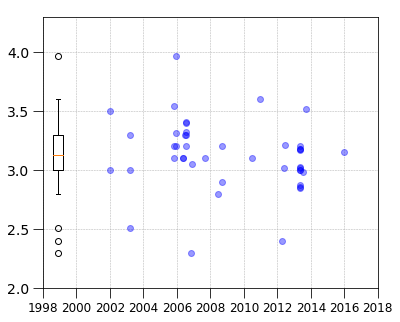

In [467]:
import datetime

# Plot canvas
fig, ax = plt.subplots(1, 1, figsize=(6,5))

# global parameters
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=14)

# plot date vs res
plt.plot_date(data.deposition_date, 
              data.resolution,
              color="blue",
              alpha=0.4)

ax.grid(linestyle='--', linewidth='0.5')
ax.tick_params(size=10)

# customize
ax.set_ylim([2.0, 4.3])
ax.set_xlim([datetime.date(1999, 1, 1), 
             datetime.date(2017, 1, 1)])

# Save label and tick positions to reset later
plt.draw()
locs = ax.get_xticks()
labs = ax.get_xticklabels()

# boxplot
d = ['1998']
x = [locs[1]-400]
plt.boxplot(data['resolution'], labels = d, 
            positions = x, widths = 210)

# Reset the xtick locations.
ax.set_xticks(locs)
ax.set_xticklabels(labs)

# show
plt.show()

Ramachandran Analysis
----------------------------

Use two routines, one in pyRosetta and the other in BioPython.

In [85]:
print(data)

     PDB                              molecule gene_name        assembly  \
0   1KPK  H(+)/Cl(-) exchange transporter ClcA    JW5012      homo-dimer   
1   1KPL  H(+)/Cl(-) exchange transporter ClcA   STM0203      homo-dimer   
2   1OTS  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
3   1OTT  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
4   1OTU  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
5   2EXW  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
6   2EXY  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
7   2EZ0  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
8   2FEC  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
9   2FED  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
10  2FEE  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
11  2H2P  H(+)/Cl(-) exchange transporter ClcA    JW5012  hetero-hexamer   
12  2H2S  H(